# **Water Management and Forecasting**
### **Project Backgroung**
The arid climate of several Algerian regions and the water-stressed region of Bhopal, effective water management and forecasting are crucial. This project aims to harness the power of machine learning to address the unique water resource challenges faced by both regions. By creating an open-source solution, we aim to empower Algeria and Bhopal to make informed decisions, optimize resource allocation, and build resilient water infrastructure for a sustainable future.
### **Project Goals**
**Develop a Comprehensive Open-Source Water Management and Forecasting System:** Create a user-friendly platform tailored to the specific needs of Algeria and Bhopal, integrating machine learning algorithms for precise water forecasting and efficient water resource management.

- **Enhance Water Resource Utilization:** Improve the sustainable use of water resources in both regions by providing accurate forecasts and real-time monitoring.
- **Capacity Building:** Empower local stakeholders in Algeria and Bhopal with the knowledge and tools necessary to make well-informed decisions about water management.
- **Community Engagement:** Foster collaboration among local government agencies, NGOs, and the research community to collectively address water-related challenges in both regions.

# **Import Modules**

In [6]:
#### Import the libraries needed
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from pathlib import Path
import os

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from statsmodels.tsa.stattools import adfuller, grangercausalitytests
import statsmodels.api as sm

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.filterwarnings('ignore')
%matplotlib inline

# **Set Environment**

In [2]:
import plotly.io as pio
pio.renderers.default = "colab"

In [3]:
# Set up directory
working_directory = Path.cwd()
parent = working_directory.parents[2]
# data directory
processed_data_directory = parent / 'src' / 'data' / 'processed'

In [4]:
# Set pd.options to add slide bars
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

In [5]:
# Set default title color
plt.style.use('fivethirtyeight')

# set default plt figure size
plt.rcParams["figure.figsize"] = [10, 5]
# suptitle
plt.rcParams["figure.titlesize"] = 22
plt.rcParams["figure.titleweight"] = "bold"
plt.rcParams['text.color'] = '#333333'
# title
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["axes.titleweight"] = "bold"
plt.rcParams["axes.titlelocation"] = "left"
plt.rcParams['axes.titlecolor'] = '#333333'
# label
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams['axes.labelcolor'] = '#333333'
# spines
plt.rcParams["axes.spines.bottom"] = True
plt.rcParams["axes.spines.left"] = True
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
# tick
plt.rcParams['xtick.color'] = "#333333"
plt.rcParams['ytick.color'] = "#333333"

# **Load data**
* The dataset contains 1096 data points
* No null values
* No duplicates


### **Feature Name and its Description**
* **'precipitation_sum'**: Sum of Daily Precipitation (mm)
* **"temperature_2m_mean"**: Mean Air Temperature at 2m above Ground (°C )
* **'wind_speed_10m_max'**: Maximum Wind Speed on a Day (kmh)
* **'wind_direction_10m_dominant'**: Dominant Wind Direction (°)
* **'et0_fao_evapotranspiration'**: Daily Sum of ET₀ Reference Evapotranspiration of a Well Watered Grass Field (mm)

In [8]:
file = os.path.join(processed_data_directory, "bhopal_nat_metrics.csv")
df = pd.read_csv(file, parse_dates=['time'])
df.head()

,id_reg_nat,time,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,et0_fao_evapotranspiration,id_area
0,1,2020-11-19,23.3,1.2,14.8,255,2.84,1
1,2,2020-11-20,21.2,0.0,12.5,29,3.39,1
2,3,2020-11-21,18.4,0.0,10.2,45,3.64,1
3,4,2020-11-22,18.3,0.0,10.0,72,3.63,1
4,5,2020-11-23,20.1,0.0,11.2,87,3.54,1


In [9]:
print(df['time'].min())
print(df['time'].max())

2020-11-19 00:00:00
2023-11-19 00:00:00


In [8]:
df.shape

(1096, 8)

In [9]:
# Check columns
num_cols = df.select_dtypes(include=[np.number]).columns
print(f"Numerical Columns: {num_cols}")
print()

cat_cols = df.select_dtypes(exclude=[np.number]).columns
print(f"Categorical Columns: {cat_cols}")

Numerical Columns: Index(['id_reg_nat', 'temperature_2m_mean', 'precipitation_sum',
       'wind_speed_10m_max', 'wind_direction_10m_dominant',
       'et0_fao_evapotranspiration', 'id_area'],
      dtype='object')

Categorical Columns: Index(['time'], dtype='object')


# **Descriptive Statistics**

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096 entries, 0 to 1095
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   id_reg_nat                   1096 non-null   int64         
 1   time                         1096 non-null   datetime64[ns]
 2   temperature_2m_mean          1096 non-null   float64       
 3   precipitation_sum            1096 non-null   float64       
 4   wind_speed_10m_max           1096 non-null   float64       
 5   wind_direction_10m_dominant  1096 non-null   int64         
 6   et0_fao_evapotranspiration   1096 non-null   float64       
 7   id_area                      1096 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(3)
memory usage: 68.6 KB


In [11]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
id_reg_nat,1096.0,548.5,1.0,274.75,548.5,822.25,1096.0,316.532252
time,1096,2022-05-20 12:00:00,2020-11-19 00:00:00,2021-08-19 18:00:00,2022-05-20 12:00:00,2023-02-18 06:00:00,2023-11-19 00:00:00,NaN
temperature_2m_mean,1096.0,24.722536,12.3,21.275,25.1,27.6,36.4,5.016001
precipitation_sum,1096.0,3.969617,0.0,0.0,0.0,1.8,236.8,12.260341
wind_speed_10m_max,1096.0,15.619434,6.6,12.0,14.75,18.7,42.9,4.745245
wind_direction_10m_dominant,1096.0,187.09854,1.0,65.0,238.5,280.0,359.0,110.274565
et0_fao_evapotranspiration,1096.0,4.736615,0.83,3.34,4.21,5.795,10.9,2.039185
id_area,1096.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0


In [12]:
# Drop 'id_area' and 'id_reg_nat'
df.drop(['id_area', 'id_reg_nat'], inplace=True, axis=1)

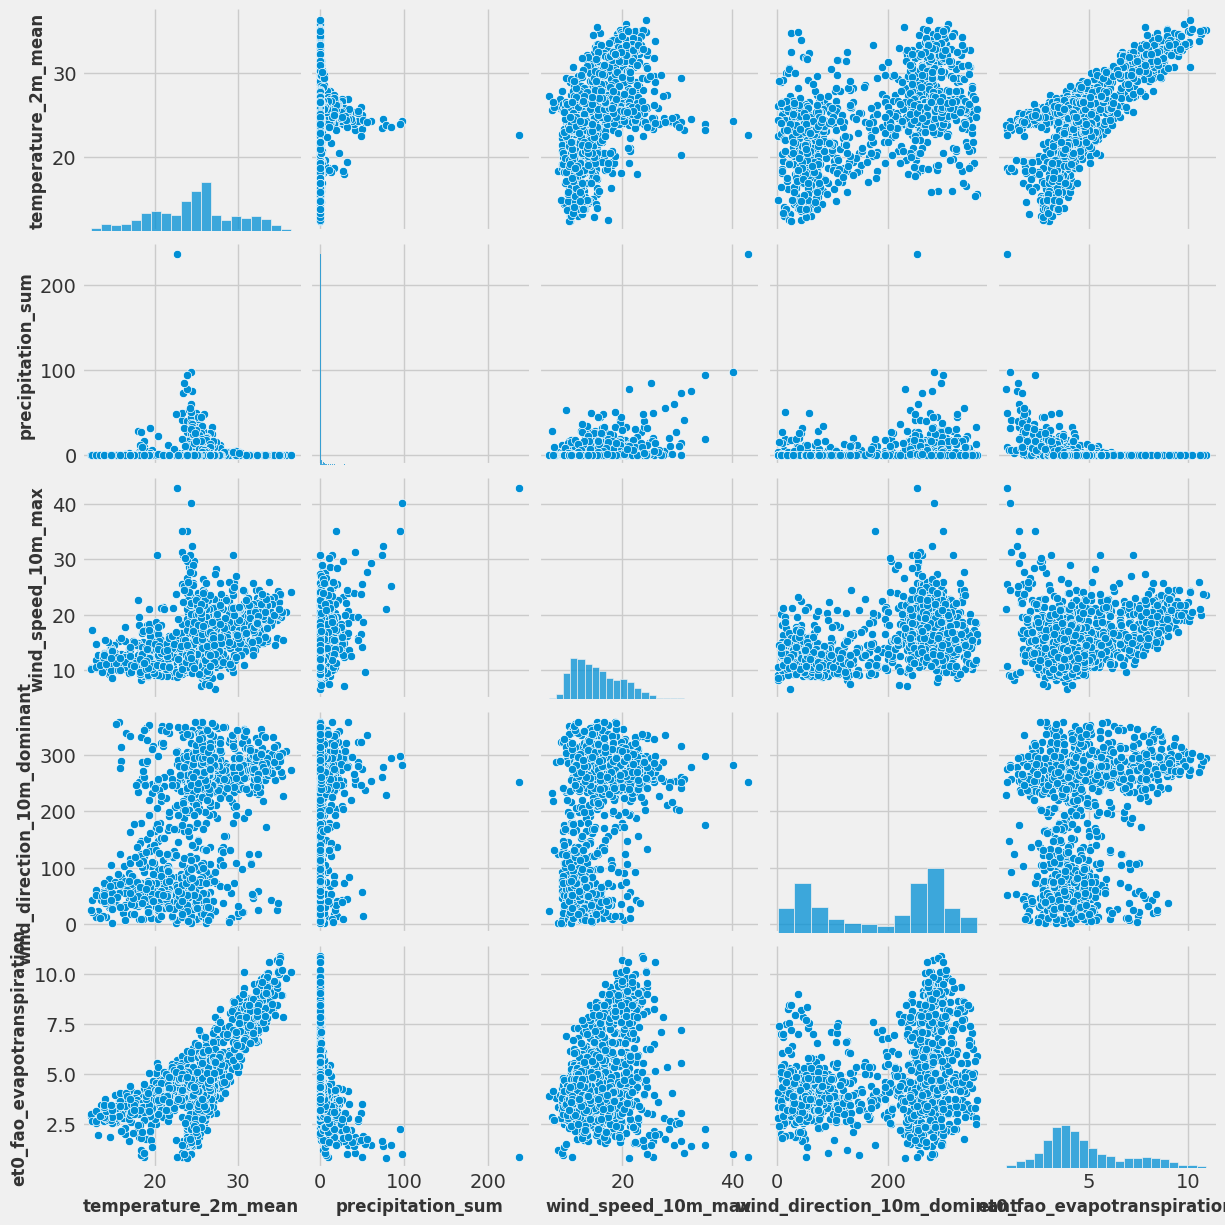

In [13]:
# Check distribution and bivariate
sns.pairplot(df);

# **Duplicate Handling**

In [14]:
# Check duplicates
df.duplicated().sum()

0

# **Exploratory Data Analysis**

* Bhopal is the capital city of Madhya Pradesh state in central India. It lies on the Malwa Plateau, about 500 metres above sea level, and near the northern edge of the Vindhya Range. Bhopal has a mild climate with dry, hot summers and cool winters. Summer in Bhopal is late March through June followed by the monsoon or rainny season. Precipitation is concentrated during the monsoon season, which typically starts from late June to early October. Bhopal's annual rainfall is concentrated in the monsoon season.

* The precipitaion level in Bhopal is separated in 2 distinct wet and dry seasons. Precipitation level is close to zero from October through April. The rainfall volume is concentrated in the wet rainny season from May through the begining of October.

* The temperature and evapotranspiration reache to their peak in May, which is right before the monsoon season starts bringing annual rainfalls in the rigeon. This is critical to predict accurate precipitation along with temperature and evapotranspiration.

* The line charts show the seasonal pattern in temperature, precipitation, wind speed, wind direction and evapotranspiration. Seasonality should be checked

* **Univariate Analysis**
* Plots show seasonality, so statistical tests need to be conducted to check stationality

In [15]:
# Assuming you have a DataFrame 'df'
fig = px.line(df, x="time", y='precipitation_sum', title='Sum of Daily Precipitation (mm)')

# Specify the figure size
fig.update_layout(
    autosize=False,
    width=1200,
    height=400,)

fig.show(renderer="colab")

In [41]:
# Assuming you have a DataFrame 'df'
fig = px.line(df, x="time", y="temperature_2m_mean", title='Mean Air Temperature at 2m above Ground (°C )')

# Specify the figure size
fig.update_layout(
    autosize=False,
    width=1200,
    height=400,
)

fig.show(renderer="colab")

In [42]:
# Assuming you have a DataFrame 'df'
fig = px.line(df, x="time", y='wind_speed_10m_max', title='Maximum Wind Speed on a Day (kmh)')

# Specify the figure size
fig.update_layout(
    autosize=False,
    width=1200,
    height=400,
)

fig.show(renderer="colab")

In [43]:
# Assuming you have a DataFrame 'df'
fig = px.line(df, x="time", y='wind_direction_10m_dominant', title='Dominant Wind Direction (°)')

# Specify the figure size
fig.update_layout(
    autosize=False,
    width=1200,
    height=400,
)

fig.show(renderer="colab")

In [44]:
# Assuming you have a DataFrame 'df'
fig = px.line(df, x="time", y='et0_fao_evapotranspiration', title='Daily Sum of ET₀ Reference Evapotranspiration of a Well Watered Grass Field (mm)')

# Specify the figure size
fig.update_layout(
    autosize=False,
    width=1200,
    height=400,
)

fig.show(renderer="colab")

In [11]:
# Create features
df['year'] = df['time'].dt.year
df['month'] = df['time'].dt.month
df['year_month'] = df['time'].dt.strftime('%Y_%m')
df['year_week'] = df['time'].dt.strftime('%Y_%U')
df['season'] = ['wet season' if m in [5, 6, 7, 8, 9, 10] else 'dry season' for m in df['time'].dt.month]

In [21]:
df.head()

,time,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,et0_fao_evapotranspiration,year,month,year_month,year_week,season
0,2020-11-19,23.3,1.2,14.8,255,2.84,2020,11,2020_11,2020_46,dry season
1,2020-11-20,21.2,0.0,12.5,29,3.39,2020,11,2020_11,2020_46,dry season
2,2020-11-21,18.4,0.0,10.2,45,3.64,2020,11,2020_11,2020_46,dry season
3,2020-11-22,18.3,0.0,10.0,72,3.63,2020,11,2020_11,2020_47,dry season
4,2020-11-23,20.1,0.0,11.2,87,3.54,2020,11,2020_11,2020_47,dry season


In [12]:
# Mean by weekly, monthly, yearly
weekly_avg = df.groupby('year_week')[['temperature_2m_mean',
                                   'precipitation_sum',
                                   'wind_speed_10m_max',
                                   'wind_direction_10m_dominant',
                                   'et0_fao_evapotranspiration']].mean()

monthly_avg = df.groupby('year_month')[['temperature_2m_mean',
                                   'precipitation_sum',
                                   'wind_speed_10m_max',
                                   'wind_direction_10m_dominant',
                                   'et0_fao_evapotranspiration']].mean()

yearly_avg = df.groupby('year')[['temperature_2m_mean',
                                   'precipitation_sum',
                                   'wind_speed_10m_max',
                                   'wind_direction_10m_dominant',
                                   'et0_fao_evapotranspiration']].mean()

# Aggregated month total
monthly_precip_sum = df.groupby('month')['precipitation_sum'].agg(['mean', 'sum'])

yearly_precip_sum = df.groupby('year')['precipitation_sum'].sum()

seasonal_precip_sum = df.groupby('season')['precipitation_sum'].agg(['mean', 'sum'])

In [45]:
# Weekly average
cols = ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant', 'et0_fao_evapotranspiration']
subtitles = ('temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant', 'et0_fao_evapotranspiration')
r = 1
c = 5
fig = make_subplots(rows=r, cols=c, subplot_titles=subtitles)

# Add traces
for i in range(len(cols)):
    fig.add_trace(go.Scatter(x=weekly_avg.index, y=weekly_avg[cols[i]], mode='lines'), row=1, col=i+1)

# Specify the figure size
fig.update_layout(
    autosize=False,
    width=1500,
    height=300,
)

fig.update_layout(title='<b>Weekly Average</b>', title_font=dict(size=24))

fig.show(renderer="colab")

In [46]:
# Monthly average
cols = ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant', 'et0_fao_evapotranspiration']
subtitles = ('temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant', 'et0_fao_evapotranspiration')
r = 1
c = 5
fig = make_subplots(rows=r, cols=c, subplot_titles=subtitles)

# Add traces
for i in range(len(cols)):
    fig.add_trace(go.Scatter(x=monthly_avg.index, y=monthly_avg[cols[i]], mode="lines"), row=1, col=i+1)

# Specify the figure size
fig.update_layout(
    autosize=False,
    width=1500,
    height=300,
)

fig.update_layout(title='<b>Monthly Average</b>', title_font=dict(size=24))

fig.show(renderer="colab")

In [47]:
# Yearly average
cols = ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant', 'et0_fao_evapotranspiration']
subtitles = ('temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant', 'et0_fao_evapotranspiration')
r = 1
c = 5
fig = make_subplots(rows=r, cols=c, subplot_titles=subtitles)

# Add traces
for i in range(len(cols)):
    fig.add_trace(go.Bar(x=yearly_avg.index, y=yearly_avg[cols[i]]), row=1, col=i+1)

# Specify the figure size
fig.update_layout(
    autosize=False,
    width=1500,
    height=300,
)

fig.update_layout(title='<b>Yearly Average</b>', title_font=dict(size=24))

fig.show(renderer="colab")

In [16]:
# Yearly total precipitation
fig = go.Figure(
    data=[go.Bar(x=yearly_precip_sum.index, y=yearly_precip_sum.values)],
    layout_title_text="Precipitation Total by Year"
)
# Specify the figure size
fig.update_layout(
    autosize=False,
    width=600,
    height=300)

fig.show(width=600, height=300,renderer="vscode")

In [15]:
# Month total precipitation
fig = go.Figure(
    data=[go.Bar(x=monthly_precip_sum.index, y=monthly_precip_sum['mean'])],
    layout_title_text="Average Precipitation by Month"
)
# Specify the figure size
fig.update_layout(
    autosize=False,
    width=600,
    height=300)

fig.show(width=600, height=300, renderer="vscode")

In [14]:
# Average precipitation by season
fig = go.Figure(
    data=[go.Bar(x=seasonal_precip_sum .index, y=seasonal_precip_sum ['mean'])],
    layout_title_text="Average Precipitation by Season"
)
# Specify the figure size
fig.update_layout(
    autosize=False,
    width=600,
    height=300)

fig.show(renderer="vscode")

* **Bivariate & Multivariate Analysis**
* 'temperature_2m_mean', 'wind_speed_10m_max', 'precipitation_sum', and 'et0_fao_evapotranspiration' show seasonality pattern
*  Especially, 'temperature_2m_mean', 'wind_speed_10m_max' and 'et0_fao_evapotranspiration'have the similarity where the both starts increasing from January and decreasing from June.

In [29]:
# Check the pattern of features
from sklearn.preprocessing import MinMaxScaler
scale = MinMaxScaler()
cols = ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant', 'et0_fao_evapotranspiration']
df_scaled = scale.fit_transform(df[cols])

In [30]:
df_scaled = pd.DataFrame(df_scaled, columns=cols, index=df['time'])
df_scaled.head()

,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,et0_fao_evapotranspiration
time,,,,,
2020-11-19,0.456432,0.005068,0.225895,0.709497,0.199603
2020-11-20,0.369295,0.000000,0.162534,0.078212,0.254220
2020-11-21,0.253112,0.000000,0.099174,0.122905,0.279047
2020-11-22,0.248963,0.000000,0.093664,0.198324,0.278054
2020-11-23,0.323651,0.000000,0.126722,0.240223,0.269116


In [51]:
# Scale 5 features and check the seasonality patterns
data=[]
for col in cols:
    line = go.Scatter(x=df_scaled.index, y=df_scaled[col], mode='lines', name=col)
    data.append(line)

# Create a layout
layout = go.Layout(title='Temperature, Precipitaion, Wind speed, Wind Direction, Evapotranspiration in Bhopal, India', width=1200, height=300)

# Create a Figure and plot it
fig = go.Figure(data=data, layout=layout)
fig.show(renderer="colab")

In [52]:
# Visualize the wind speed and direction
fig = go.Figure()

fig.add_trace(go.Barpolar(
    r=df['wind_speed_10m_max'],
    theta=df['wind_direction_10m_dominant'],
    name='Wind Speed',
    marker_color='rgb(51,119,255)',
    marker_line_color='rgb(51,119,255)',
    marker_line_width=5))

fig.update_layout(
    title='Wind Direction Distribution',
    width=400,
    height=400,
    font_size=16,
    legend_font_size=16,
    polar_radialaxis_ticksuffix='kph',
    polar_angularaxis_rotation=0,)

fig.show(renderer="colab")

In [53]:

fig = px.scatter(df, x='precipitation_sum', y='wind_speed_10m_max', color='month', size='et0_fao_evapotranspiration')
fig.show(renderer="colab")

# **Correlation Matrix**
* Check colliniality between features
* 'temperature_2m_mean' and 'et0_fao_evapotranspiration' are relatively high correlation

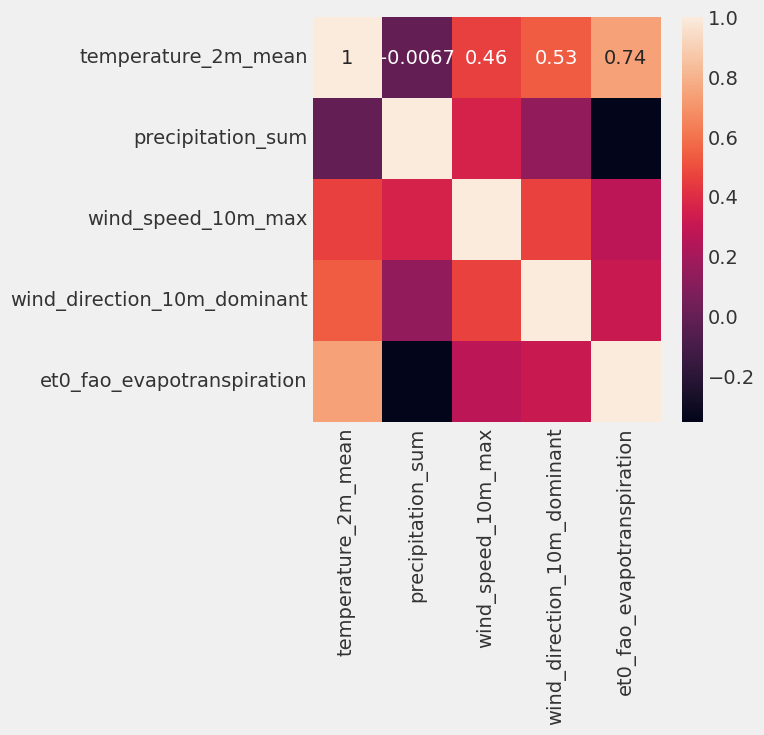

In [34]:
fig = plt.figure(figsize=(5, 5))
correlation = df[cols].corr()
sns.heatmap(correlation, annot=True);

# **Statistical Tests**
* Some time series algorighms such as ARIMA, SARIMA, or VAR require the series to be stational
* Our data shows distinctive seasonal pattern, thus it needs to check the stationality
* We will check stationality using both visual and statistical test
* Even the plot shows the seasonality, it looks consistent, thus 'precipitation_sum' is detected as stational
## **Seasonal Decomposition Plot**
## **Augmented Dickey_Fuller Test**
* The ADF test was conducted to all 5 features.
* The p-value of the test result against 'temperature_2m_mean' was greater than 0.05, thus 'temperature_2m_mean' was not statinal
* 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant', and 'et0_fao_evapotranspiration' were stational
    * Null Hypothesis: 'precipitation_sum' is not stational
    * Alternative Hypothesis: 'precipitation_sum' is stational
## **Grander's Causality Test**
* Grander's Causality Tests is used to determine whether one time series is causal to another time series
* Granger's Causality test results indicate the causality relation exists shown as below:
* wind_speed_10m_max --> temperature_2m_mean, precipitation_sum
* wind_direction_10m_dominant --> precipitation_sum, wind_speed_10m_max
* et0_fao_evapotranspiration --> wind_speed_10m_max, wind_direction_10m_dominant, precipitation_sum
    * Null Hypothesis: col1 DOES NOT explain the variation in col2
    * Alternative Hypothesis: col1 DOES explain the variation in col2

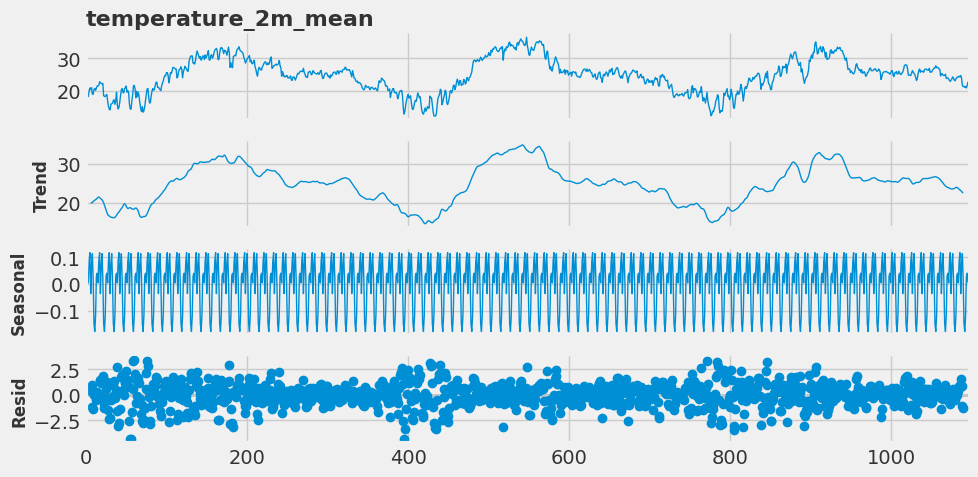

In [35]:
# Seasonal decomposition plot
decomposition = sm.tsa.seasonal_decompose(df['temperature_2m_mean'], model='additive', period=12)
# Change the line width
fig = decomposition.plot()
for ax in fig.axes:
    for line in ax.get_lines():
        line.set_linewidth(1)

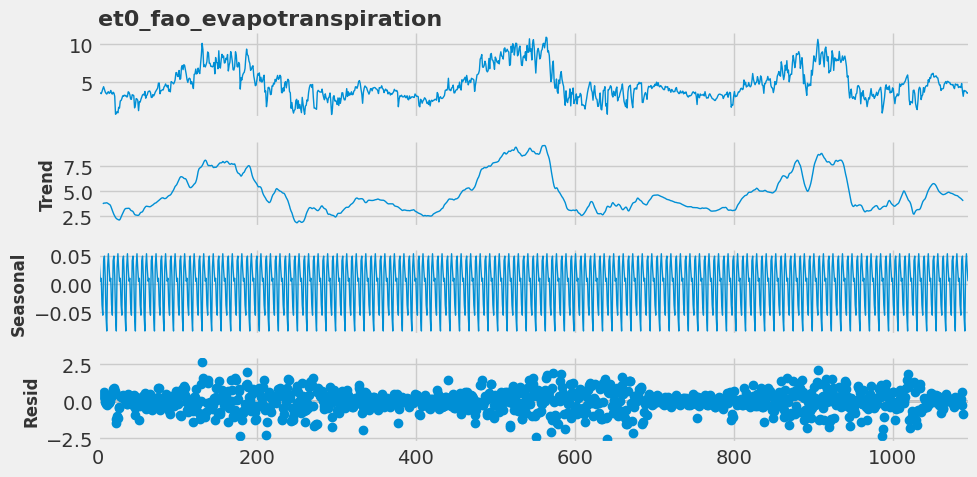

In [36]:
# Seasonal decomposition plot
decomposition = sm.tsa.seasonal_decompose(df['et0_fao_evapotranspiration'], model='additive', period=12)
# Change the line width
fig = decomposition.plot()
for ax in fig.axes:
    for line in ax.get_lines():
        line.set_linewidth(1)

## **Augumented Dickey Fuller Test**
* The test result indicates 'temperature_2m_mean' is not stational.
* When 'temperature_2m_mean' is predicted using ARIMA, SARIMA, VAR and other algorighms that has a stationarity assumption, it has to be transformed until it becomes stational.

In [37]:
# Function to print the ADF result
def adf(ts):
    # Conduct Augmented Dickey_Fuller Test
    adf_result = adfuller(ts)
    # Print the ADF test results
    print(col)
    print(f"ADF Statistic: {adf_result[0]}")
    print(f"p-value: : {adf_result[1]}")
    print('Critical Values:')
    for key, value in adf_result[4].items():
        print(f"\t{key}: {value}")

    if adf_result[1] <= 0.05:
        print("The series is stationary")
    else:
        print("The series is NOT stationary")
    print()

In [38]:
# Run the ADF test for all features
for col in cols:
    adf(df[col])

temperature_2m_mean
ADF Statistic: -2.4382063746249165
p-value: : 0.131241954315988
Critical Values:
	1%: -3.436380183743342
	5%: -2.8642025841870655
	10%: -2.568187648736553
The series is NOT stationary

precipitation_sum
ADF Statistic: -5.134552339727203
p-value: : 1.1941355080341804e-05
Critical Values:
	1%: -3.436396912213269
	5%: -2.864209963080287
	10%: -2.5681915787162484
The series is stationary

wind_speed_10m_max
ADF Statistic: -3.6182892767374653
p-value: : 0.005420849996344191
Critical Values:
	1%: -3.436441978605957
	5%: -2.864229841568573
	10%: -2.5682021659802934
The series is stationary

wind_direction_10m_dominant
ADF Statistic: -3.9125355295754907
p-value: : 0.0019445050917828075
Critical Values:
	1%: -3.4364081161854747
	5%: -2.8642149051061954
	10%: -2.5681942108302214
The series is stationary

et0_fao_evapotranspiration
ADF Statistic: -3.8960461466947565
p-value: : 0.002064138746718113
Critical Values:
	1%: -3.436358022565693
	5%: -2.8641928088747743
	10%: -2.56818

## **Granger Causality Test**
* Check a variable is causal to the other variable
* Granger's Causality test results indicate the causality relation exists shown as below:
* wind_speed_10m_max --> temperature_2m_mean, precipitation_sum
* wind_direction_10m_dominant --> precipitation_sum, wind_speed_10m_max
* et0_fao_evapotranspiration --> wind_speed_10m_max, wind_direction_10m_dominant, precipitation_sum

In [39]:
# # Function to return Granger's Causality Test result
# def granger(ts1, ts2, max_lag=1, verbose=False):
#     granger_results = grangercausalitytests([ts1, ts2], maxlag=max_lag, verbose=False)
#     p_value = granger_results[1][0]['params_ftest'][1]
#     f_test_stat = granger_results[1][0]['params_ftest'][0]

#     print(f"Test Grander's Causality for {ts2} to {ts1}")
#     print(f"p-value: {p_value}")
#     print(f"F Test Statistic: {f_test_stat}")
#     if p_value <= 0.05:
#         print(f"{ts2} explaines variation in {ts1}")
#     else:
#         print(f"{ts2} DOES NOT explaines variation in {ts1}")

In [40]:
for i in range(len(cols) - 1):
    for j in range(i + 1, len(cols)):
        # granger(df[cols[i]], df[cols[j]])
        print(f"Testing causality for: {cols[i]} -> {cols[j]}")
        granger_test_result = grangercausalitytests(df[[cols[i], cols[j]]], maxlag=1)


Testing causality for: temperature_2m_mean -> precipitation_sum

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6244  , p=0.4296  , df_denom=1092, df_num=1
ssr based chi2 test:   chi2=0.6262  , p=0.4288  , df=1
likelihood ratio test: chi2=0.6260  , p=0.4288  , df=1
parameter F test:         F=0.6244  , p=0.4296  , df_denom=1092, df_num=1
Testing causality for: temperature_2m_mean -> wind_speed_10m_max

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.9966  , p=0.0048  , df_denom=1092, df_num=1
ssr based chi2 test:   chi2=8.0186  , p=0.0046  , df=1
likelihood ratio test: chi2=7.9893  , p=0.0047  , df=1
parameter F test:         F=7.9966  , p=0.0048  , df_denom=1092, df_num=1
Testing causality for: temperature_2m_mean -> wind_direction_10m_dominant

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8077  , p=0.1791  , df_denom=1092, df_num=1
ssr based chi2 test:   chi2=1.8126  , p=0.1782  , df=1
likelihood rat

# **Insights**
* When 'temperature_2m_mean' is predicted using ARIMA, SARIMA, VAR and other algorighms that has a stationarity assumption, it has to be transformed until it becomes stational.
* Granger's Causality test results indicate the causality relation exists shown as below:
* wind_speed_10m_max --> temperature_2m_mean, precipitation_sum
* wind_direction_10m_dominant --> precipitation_sum, wind_speed_10m_max
* et0_fao_evapotranspiration --> wind_speed_10m_max, wind_direction_10m_dominant, precipitation_sum
* When a multivariate time series algorithm is used, these combination of variables can be used.